# Optimización de Parámetros - DL - RNN

In [1]:
## Get current work directory to load all the custom modules
from pathlib import Path
import os
import sys
BASE_DIR = Path().absolute().resolve(strict=True).parent.parent.parent
if str(BASE_DIR) not in sys.path:
    sys.path.append(str(BASE_DIR))

In [2]:
DATA_PATH = os.path.join(BASE_DIR, 'data', 'gruas')
print(DATA_PATH)

/workspace/Externos/TimeSeries/BenchMark/data/gruas


In [3]:
import pandas as pd


In [4]:
import optuna
import datetime

In [5]:
from modulos.arima.gruas.general import format_timeseries, show_results_r2, arima_forecasting, total_forecasting, show_optimizer_results
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import numpy as np
import tensorflow as tf


from modulos.LR.gruas.generals import make_lags
from modulos.DL.gruas.custom_models import ForecastinModel, cross_val_score_dl
from modulos.DL.gruas.optimizer import DLOptimizer

2021-12-04 11:38:04.657805: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-04 11:38:04.657833: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [6]:
data = pd.read_csv(os.path.join(DATA_PATH, 'producto.csv'), parse_dates=['Periodo'])
data.head()

,idArticulo,ventas,DescProducto,Periodo
0,tuerc,7,TUERCA,2021-05-01
1,tuerc,5,TUERCA,2020-12-01
2,tuerc,1,TUERCA,2020-11-01
3,tuerc,11,TUERCA,2020-09-01
4,tuerc,4,TUERCA,2020-06-01


In [7]:
# Pivotando las tablas y llenando de ceros las ventas que no existen.
df_time = format_timeseries(data)
df_time.tail()

idArticulo,arandel,bateriascanrec,filtrodeair,filtrodepresio,filtroderetorn,pern,soport,tuerc
Periodo,,,,,,,,
2021-06-01,0.0,0.0,2.0,2.0,4.0,0.0,0.0,0.0
2021-07-01,0.0,1.0,2.0,2.0,2.0,0.0,1.0,0.0
2021-08-01,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2021-09-01,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
2021-10-01,0.0,1.0,2.0,2.0,1.0,0.0,0.0,0.0


## Baseline DL

In [9]:
from modulos.LR.gruas.generals import split_data_train, make_timeserie

idArticulo = "filtrodepresio"
ts = df_time[idArticulo].copy()
n_lags = 4
X,y, scaler  = make_timeserie(ts, n_lags)

data = pd.concat({'Targets': y, 'Features': X}, axis=1)

data.tail(10).style.set_properties(['Targets'], **{'background-color': 'green'}) \
                   .set_properties(['Features'], **{'background-color': 'magenta'})
    

## Deel learning - serie de tiempo - cross validation

In [10]:
_ = ForecastinModel((X.iloc[0].shape[0],1), )
forecasting = ForecastinModel((X.iloc[0].shape[0],1), n_epochs=10, summary=False, )

2021-12-04 11:38:23.306498: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2021-12-04 11:38:23.306583: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: davelinux-G551JM
2021-12-04 11:38:23.306597: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: davelinux-G551JM
2021-12-04 11:38:23.306805: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.86.0
2021-12-04 11:38:23.306863: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.82.0
2021-12-04 11:38:23.306876: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 470.82.0 does not match DSO version 470.86.0 -- cannot find working devices in this configuration
2021-12-04 11:38:23.307501: I tensorflow/core/platform/cpu_feature_guard.cc:151]

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4, 1)]       0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 1)            12          ['input_1[0][0]']                
                                                                                                  
 flatten_1 (Flatten)            (None, 4)            0           ['input_1[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 1)            0           ['lstm[0][0]']                   
                                                                                              

In [11]:
mse, r2_ = cross_val_score_dl(forecasting, X, y, test_size=.1,)
print(f"Cross validation results MSE: {mse} ")
print(f"Cross validation results R2: {r2_} ")

Cross validation results MSE: 0.06459298338454886 
Cross validation results R2: -0.7443249574674382 


## Training a single model without optimization (concepto)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True)
forecasting = ForecastinModel((X.iloc[0].shape[0],1),summary=False)
forecasting.train_model(X_train, y_train, X_test,  y_test, epochs=200, batch_size=32, workers=4, verbose= 0, callback=True, logs=True, checkpoint=True)

y_fit = pd.DataFrame(forecasting.model.predict(X), index=X.index, columns=y.columns)
#y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

/home/dave-linux/.local/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


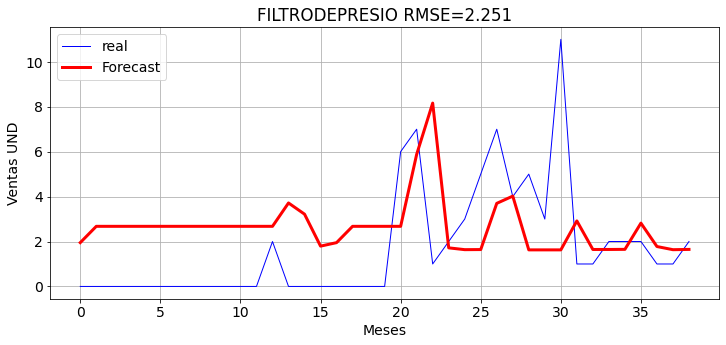

In [13]:
mse_scl = scaler.inverse_transform([[np.sqrt(mse)]])[0][0]
show_results_r2(scaler.inverse_transform(y), scaler.inverse_transform(y_fit),idArticulo, score=mse_scl, score_name='RMSE' )


# Optimizar todos los Productos        

In [14]:
optimizer = DLOptimizer(df_time, iterations=120, data_path= DATA_PATH , model='DL', subpath = None)
optimizer.run( chunk_size=4)

/home/dave-linux/.local/lib/python3.8/site-packages/sklearn/metrics/_regression.py:781: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
Trial 1 failed because of the following error: ValueError('Found input variables with inconsistent numbers of samples: [9, 0]')
Traceback (most recent call last):
  File "/home/dave-linux/.local/lib/python3.8/site-packages/optuna/study/_optimize.py", line 213, in _run_trial
    value_or_values = func(trial)
  File "/workspace/Externos/TimeSeries/BenchMark/modulos/DL/gruas/optimizer.py", line 107, in objective
    r2, mse = DL_score_cv(self.df_time[idArticulo],
  File "/workspace/Externos/TimeSeries/BenchMark/modulos/DL/gruas/optimizer.py", line 49, in DL_score_cv
    mse, r2_score = cross_val_score_dl(
  File "/workspace/Externos/TimeSeries/BenchMark/modulos/DL/gruas/custom_models.py", line 62, in cross_val_score_dl
    mse = mean_squared_error(y.iloc[-int(test_size*len(y)):

/home/dave-linux/.local/lib/python3.8/site-packages/sklearn/metrics/_regression.py:781: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


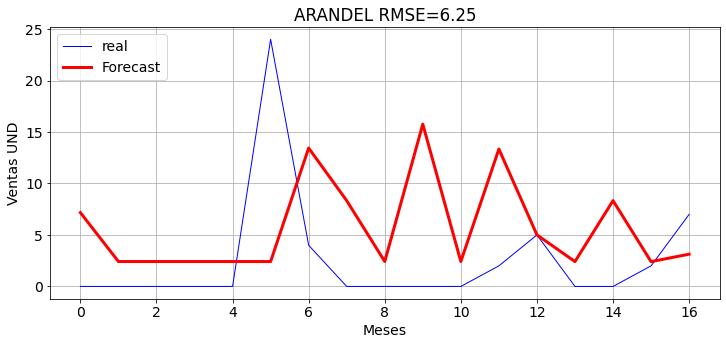

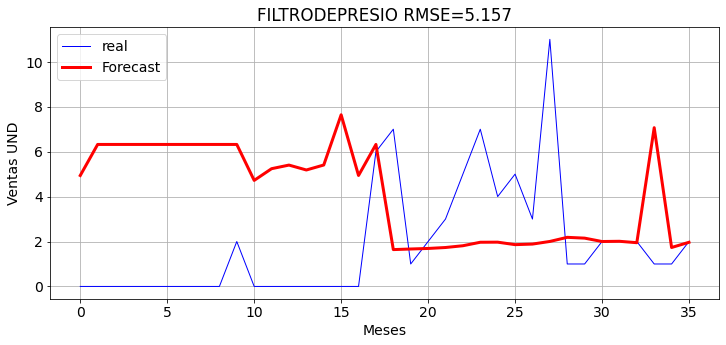

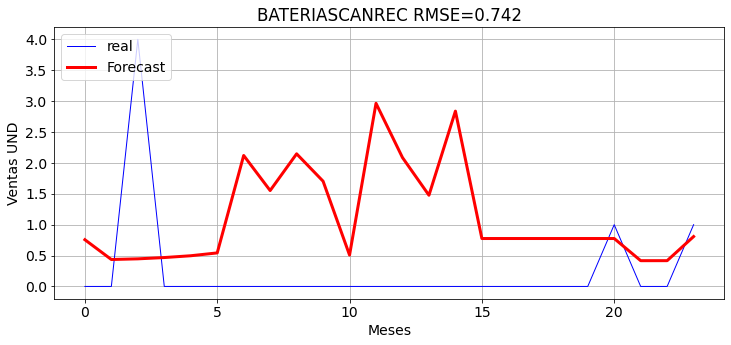

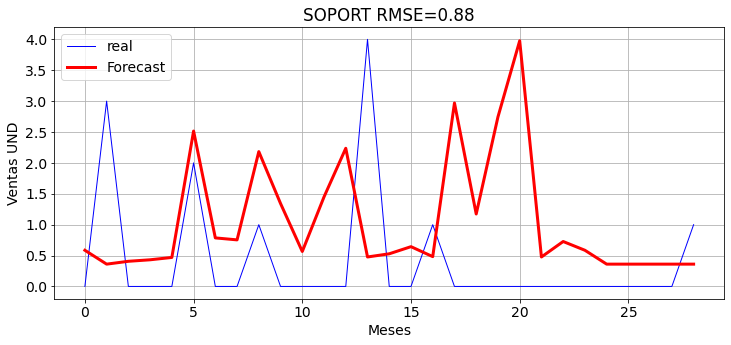

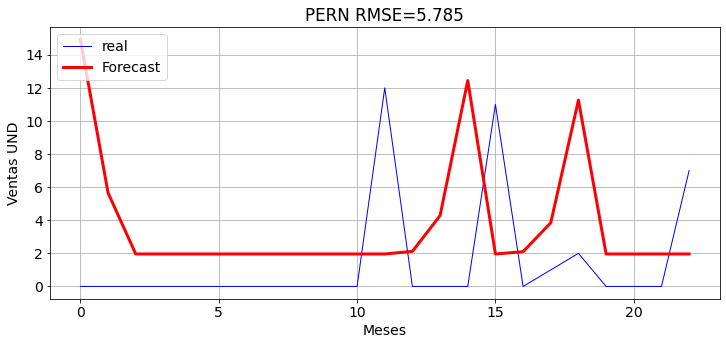

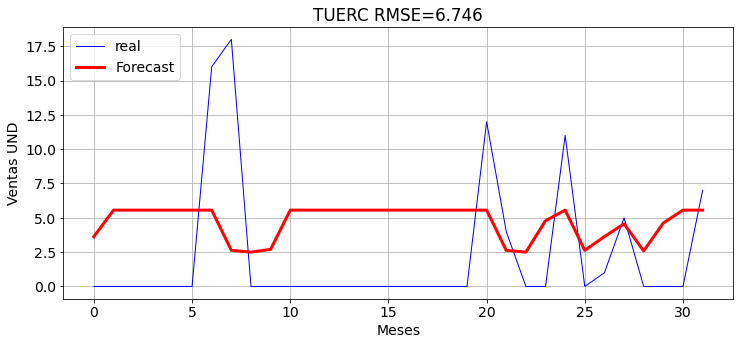

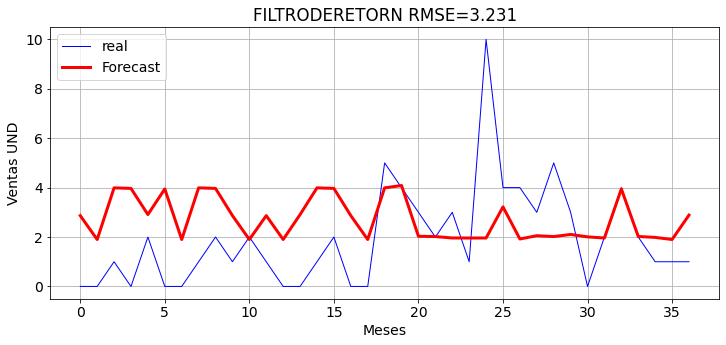

In [15]:
optimizer.print_results()

# Optimizer -  Evolution on time

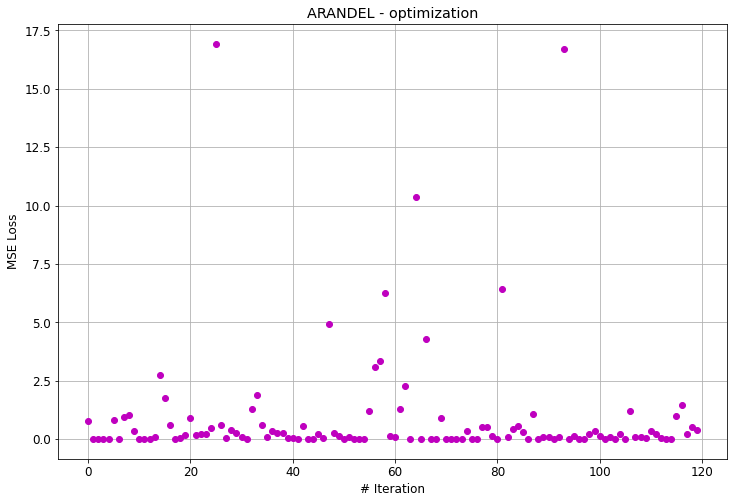

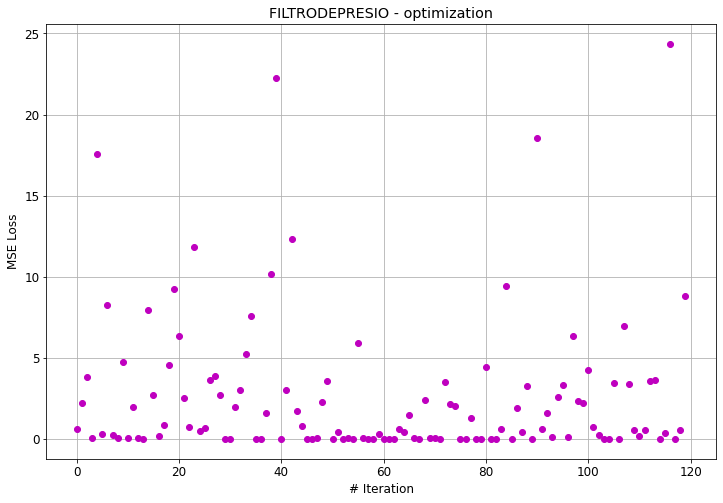

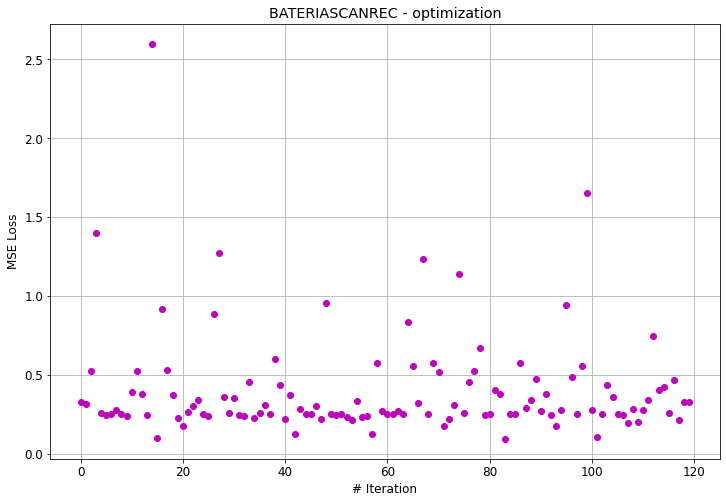

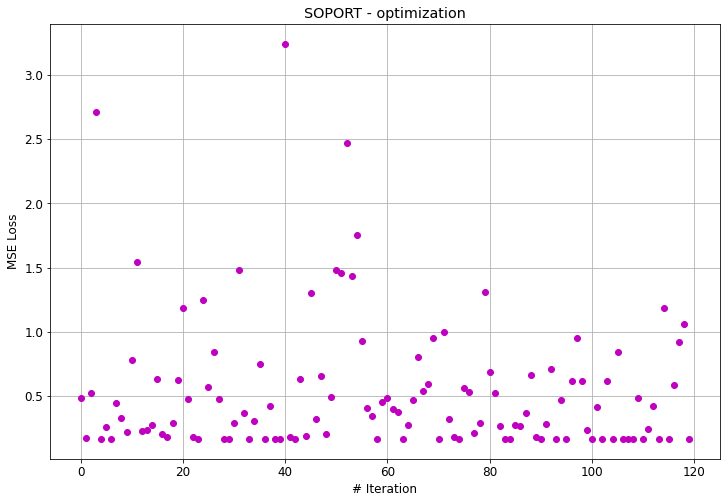

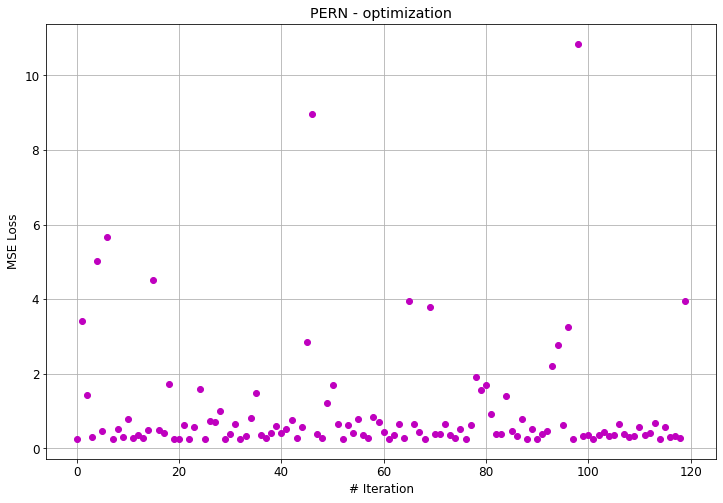

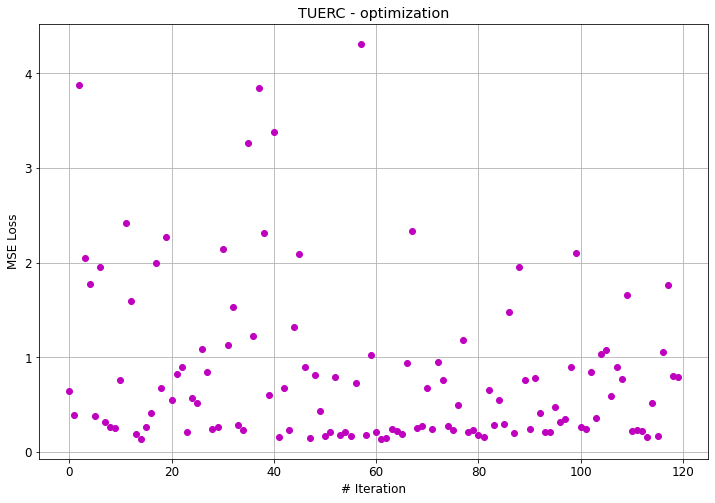

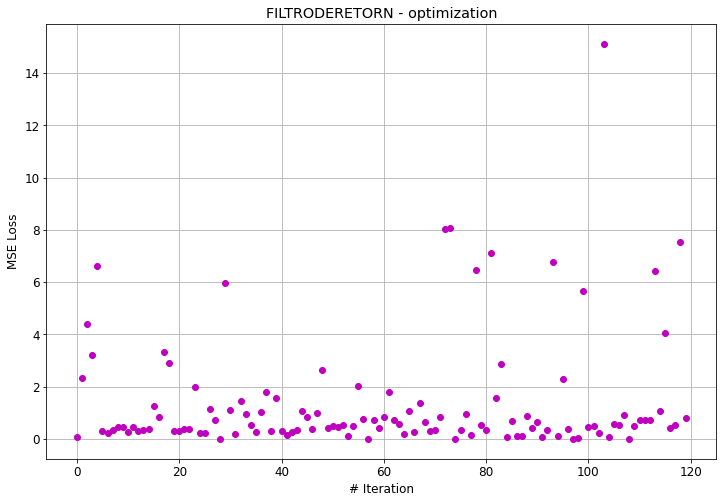

In [16]:
optimizer.print_optimizer_results()

In [17]:
optimizer.results.head()

,idArticulo,hyper,r2_test,mse_test,model
0,arandel,"{'n_lags': 9, 'random_state': 106, 'optimizer'...",NaN,0.494105,DL
1,filtrodepresio,"{'n_lags': 7, 'random_state': 2564, 'optimizer...",-55.041425,2.075234,DL
2,bateriascanrec,"{'n_lags': 12, 'random_state': 1458, 'optimize...",0.577640,0.103435,DL
3,soport,"{'n_lags': 7, 'random_state': 1396, 'optimizer...",-0.077160,0.342493,DL
4,pern,"{'n_lags': 3, 'random_state': 455, 'optimizer'...",-0.193213,0.952569,DL
